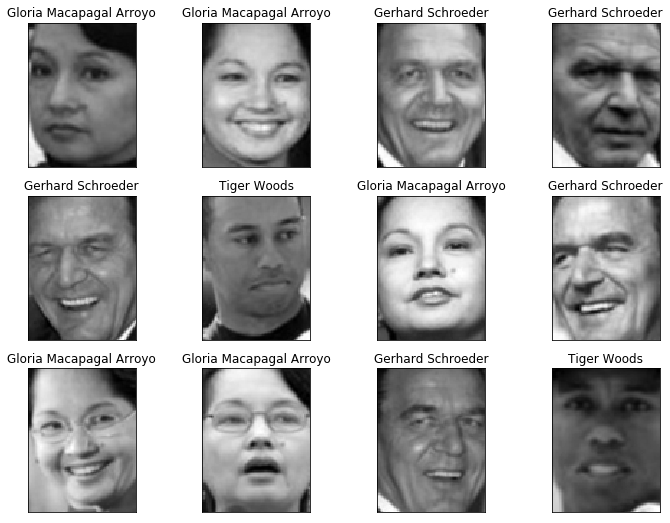

In [4]:
# 特征提取1
# 导入数据集获取工具，人脸数据集
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.8)
# print(faces.keys())
# print(faces['DESCR'])
image_shape = faces.images[0].shape
# 将图片打印出来
fig, axes = plt.subplots(3, 4, figsize=(12, 9), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title(faces.target_names[target])
    
plt.show()


In [11]:
# 导入神经网络
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
# 对数据进行拆分 这里将数据除以255是为了便于处理灰度图的像素点
X_train, X_test, y_train, y_test = train_test_split(faces.data/255, faces.target, random_state=62)
# 训练神经网络
mlp = MLPClassifier(hidden_layer_sizes=[100, 100], max_iter=2000, random_state=62)
mlp.fit(X_train, y_train)

print('moduel\'s score:{:.2f}'.format(mlp.score(X_test, y_test)))


moduel's score:0.83


In [6]:
# 通过数据白化（data whiten）提高模型的表现
# 虽然每个人的面部特征有很大差异，但如果从像素级别进行观察，差距其实没那么大，而且相邻的像素之间有很大的相关性，
# 这样一来，样本特征的输入就是冗余的了，白化的目的就是为了降低冗余性。
# 白化的过程会让样本特征之间的相关度降低，，且所有特征具有相同的方差。

# 使用白化功能处理人脸数据
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, whiten=True, random_state=62).fit(X_train)
X_train_whiten = pca.transform(X_train)
X_test_whiten = pca.transform(X_test)
print('data shape after whiten:{}'.format(X_train_whiten.shape))

# 使用白化后的数据训练神经网络
mlp.fit(X_train_whiten, y_train)
print('moduel\'s score after whiten:{:.2f}'.format(mlp.score(X_test_whiten, y_test)))
# 可以看出PCA的数据白化功能对提升神经网络模型的准确率有一定的帮助。


data shape after whiten:(89, 32)

moduel's score after whiten:0.87


In [7]:
# 特征提取2
# 使用非负矩阵分解（Non-Negative Matrix Factorization, NMF）提取特征，它是一种无监督学习。
# 矩阵分解就是把一个矩阵拆解成n个矩阵的乘积，非负矩阵分解就是原始矩阵中的元素都为非负值。
# 在原始数据无序堆放的空间中，NMF从坐标原点（0,0）引出n个向量来尽可能地吧原始特征值的信息表示出来。

# 导入NMF
from sklearn.decomposition import NMF
# 使用NMF处理数据
nmf = NMF(n_components=105, max_iter=1000, random_state=62).fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)
print('moduel shape after NMF:{}'.format(X_train_nmf.shape))

# NMF的n_components不支持浮点数，只能设置正整数
mlp.fit(X_train_nmf, y_train)
print('moduel score after NMF:{:.2f}'.format(mlp.score(X_test_nmf, y_test)))

moduel shape after NMF:(89, 105)


moduel score after NMF:0.90


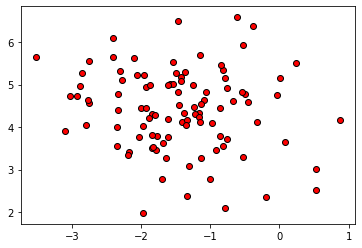

In [8]:
# 聚类算法 K均值（K-Means）聚类、凝聚聚类、DBSCAN

# K均值聚类算法 简单好用
# 导入数据集生成工具
from sklearn.datasets import make_blobs
# 生成分类数为1的数据集
blobs = make_blobs(random_state=1, centers=1)
X_blobs = blobs[0]
# 绘制散点图
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c='r', edgecolors='k')
plt.show()


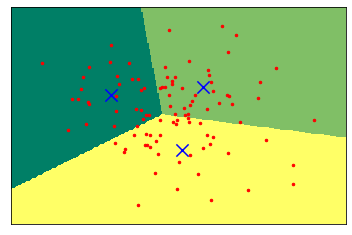

KMeans cluster label:
[2 2 0 1 1 1 2 2 0 1 2 1 2 0 2 1 1 2 0 0 1 0 2 2 2 2 1 2 2 2 0 0 2 2 1 0 1
 0 2 0 1 2 0 0 1 1 1 2 0 2 0 2 1 0 1 1 0 1 1 2 1 0 1 2 0 1 0 0 2 1 1 2 1 1
 1 2 1 2 2 0 1 0 1 1 0 2 1 2 0 0 1 2 0 0 1 1 2 1 1 2]


In [28]:
# 导入KMeans工具
from sklearn.cluster import KMeans
import numpy as np
# 要求KMeans将数据聚为3类
kmeans = KMeans(n_clusters=3, max_iter=1000)
# 拟合数据
kmeans.fit(X_blobs)

# 下面部分代码用于画图
x_min, x_max = X_blobs[:, 0].min() - 0.5, X_blobs[:, 0].max() + 0.5
y_min, y_max = X_blobs[:, 1].min() - 0.5, X_blobs[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])  # 将多维数组转换为一维数组
Z = Z.reshape(xx.shape)
plt.figure(1)  # 数字代表窗口的编号
plt.clf()  # Clear figure
plt.imshow(Z, 
           interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.summer,
           aspect='auto',
           origin='lower')
plt.plot(X_blobs[:, 0], X_blobs[:, 1], 'r.', markersize=5)

# 用蓝色叉号代表聚类的中心
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=150, linewidths=3,
            color='b', zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# 打印KMeans进行聚类的标签
print('KMeans cluster label:\n{}'.format(kmeans.labels_))
# K均值对数据进行的聚类和分类有些相似，使用0/1/2三个数字表示数据的类别，并且存储在labels_属性中。
# 它用起来十分简单，但简单的代价是不适用于处理复杂的数据集。


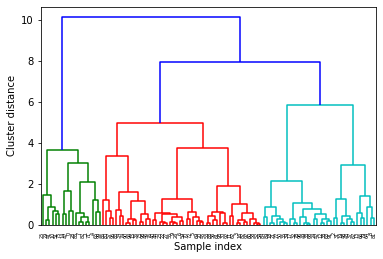

In [29]:
# 凝聚聚类算法，是一揽子算法的集合，它将每个数据点当做一个聚类，然后将相似的聚类进行合并，形成一个较大的聚类。

# 导入dendrogram和ward工具
from scipy.cluster.hierarchy import dendrogram, ward
# 使用连线的方法进行可视化
linkage = ward(X_blobs)
dendrogram(linkage)
ax = plt.gca()
# 设定坐标轴
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

# 可以看到聚类算法是自下而上的，不断合并相似的聚类中心，从而让聚类越来越少，同时每个聚类中心的距离也越来越远。
# 它和K均值凝聚算法比较相似，无法对复杂的数据集进行正确的聚类。


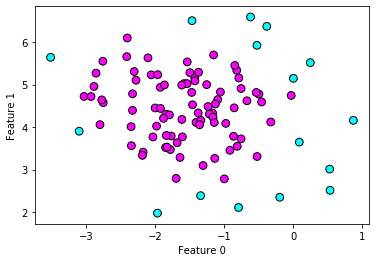

cluster tag:[-1  0 -1  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0
  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0 -1 -1  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0 -1
  0  0  0 -1]


In [31]:
# DBSCAN算法（Density-based spatial clustering of applications with noise，基于密度的有噪声应用空间聚类）
# 它会通过对空间内的密度进行检测，密度大的地方会认为是一类，密度小的地方会认为是边界，因此它不需要像K均值聚类算法那样指定n_clusters。

# 导入DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN()
# 使用DBSCAN拟合数据
clusters = db.fit_predict(X_blobs)
# 绘制散点图
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=clusters, cmap=plt.cm.cool, s=60, edgecolors='k')

plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

print('cluster tag:{}'.format(clusters))

# 中间那一坨粉色的东西就是一个聚类，而周边蓝色区域就是噪声，它的数据标签为-1。


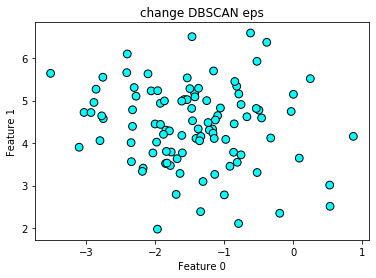

cluster_1 tag:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


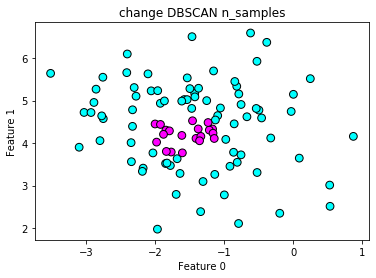

cluster_1 tag:[-1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1  0  0  0
 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0  0  0 -1  0 -1  0 -1 -1 -1
 -1 -1  0 -1 -1 -1 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1
 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1
 -1 -1 -1 -1]


In [37]:
# DBSCAN中主要的参数是eps和min_samples，
# 前者决定划入一个聚类的样本距离有多远；后者决定在某个数据点的周边，被看作是聚类核心点的个数，它的值越大，核心点数就越少，噪声也就越多。。

# 改变eps
db_1 = DBSCAN(eps=2)
# 重新拟合数据
clusters_1 = db_1.fit_predict(X_blobs)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=clusters_1, cmap=plt.cm.cool, s=60, edgecolors='k')

plt.title('change DBSCAN eps')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()
print('cluster_1 tag:{}'.format(clusters_1))
# 全部数据点都归为一类


# 改变n_samples
db_2 = DBSCAN(min_samples=20)
# 重新拟合数据
clusters_2 = db_2.fit_predict(X_blobs)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=clusters_2, cmap=plt.cm.cool, s=60, edgecolors='k')

plt.title('change DBSCAN n_samples')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()
print('cluster_1 tag:{}'.format(clusters_2))

# 可以看到蓝色数据点变多了，即噪声变多，而聚类中划分为class 0的数据点少了

